In [32]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from midiutil import MIDIFile

In [25]:
#define the collection
collection = 'lastfm' #lastfm, suno, udio

# Define your path
path = '../samples/'

song_files = os.path.join(path, collection + "_samples", 'segmented')

# List folder names inside the specified path
samples_names = [name for name in os.listdir(song_files) if os.path.isdir(os.path.join(song_files, name))]

print(samples_names)


['1390dfac67ae1ae28dcfcabb0021be8e', '2e7c3fbecc1161b4f4c530320a73b86d', '0bf9dab10d6fcdc22c9b51e75ecf47a7', '5937f12ff66a45a04b1b4634c5d3251e', '5950f83d5da35d1fee4ad358c38c7f98', '3e98160866fcc657f18c0ae17d1aab3a', '59d628e71b03e772d75fb972a85f3a33', '59890b5fef2b8bad8d46fd673e1b1c8c', '6855bf2cbb85349abd0e0d54bdc7acb6', '685c39ba94cdc20b63efd97dcbcac0dd', '6ffecf8dafa525b14ca3fd5ed7f24800', '7e0f42b9df43053baa664dbff20dd286', '7e1654f16e5cae2c2287083cf67ec53e', '81bb75015f922141763e62b9425a5ba4', 'b7ae32c12ea0be48d5d29e2337412b9a', 'c06b76a34d3c10d949e1c6c34aa804b9', 'dcb9d8c516f55f0870a1aa5a9903e8c9', 'e76afceb6a10771d5b9b78a63ddad1ce', 'e76fcfec5b190a025176d26bac47a95b', 'fd470db2f0de1ba0000e68fac3f20439']


In [26]:
song_id = 0
song = os.path.join(song_files, samples_names[song_id], 'vocals.wav')

# Load the audio as a waveform `y`, and the sampling rate `sr`
y, sr = librosa.load(song)

In [ ]:
# Step 1: Calculate RMS energy across the full track and apply amplitude threshold
frame_length = 2048
hop_length = 512
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
rms_threshold = np.mean(rms) + 0.5 * np.std(rms)  # Set threshold; adjust as needed

# Mask low-amplitude segments by setting them to zero
strong_segments = rms > rms_threshold
y_filtered = np.copy(y)
for i, keep in enumerate(strong_segments):
    if not keep:
        start = i * hop_length
        end = min(start + frame_length, len(y))
        y_filtered[start:end] = 0

In [53]:
def detect_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches, magnitudes

In [54]:
pitches, magnitudes = detect_pitch(y_filtered, sr)

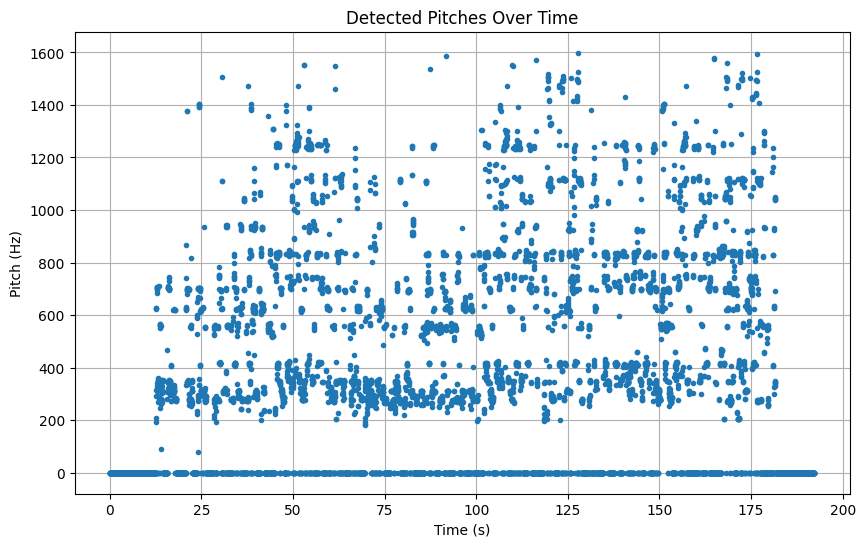

In [56]:
# Generate a time axis corresponding to the entire song duration
time_intervals = np.arange(len(pitches)) * (hop_length / sr)

# Plot the detected pitches
plt.figure(figsize=(10, 6))
plt.plot(time_intervals, pitches, marker='o', linestyle='', markersize=3)
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Detected Pitches Over Time')
plt.grid(True)
plt.show()

In [47]:
# Convert frequencies to MIDI notes
midi_notes = [int(librosa.hz_to_midi(pitch)) for pitch in pitches if pitch > 0]

# Step 3: Create a MIDI file from these notes
midi_file = MIDIFile(1)  # One track
track = 0
time = 0  # Start time
midi_file.addTrackName(track, time, "Filtered Vocal Pitches")
midi_file.addTempo(track, time, 120)  # Set tempo (adjust if needed)

# Add each pitch as a MIDI note
for midi_note in midi_notes:
    midi_file.addNote(track, 0, midi_note, time, 1, 100)  # duration of 1, velocity of 100
    time += 1  # Increment time for each note

# Save the MIDI file
with open("filtered_vocal_midi_output.mid", "wb") as output_file:
    midi_file.writeFile(output_file)

print("MIDI file created: filtered_vocal_midi_output.mid")

MIDI file created: filtered_vocal_midi_output.mid


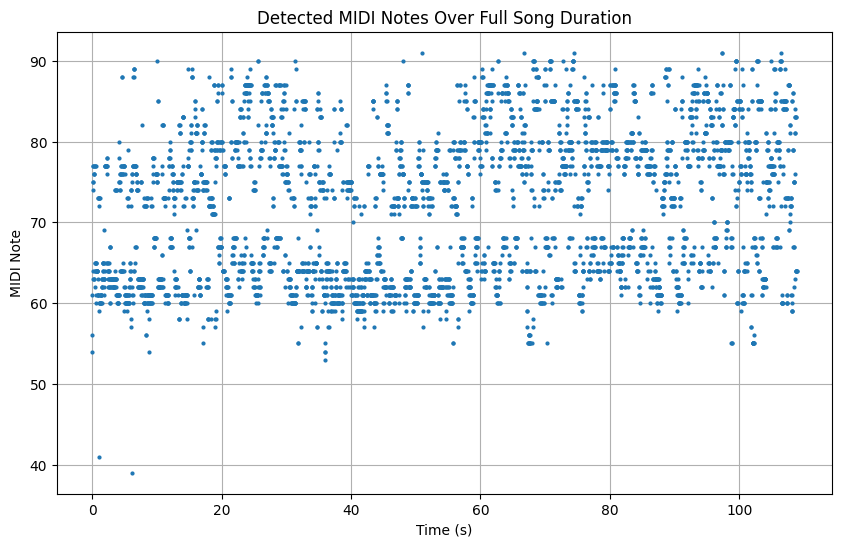

In [57]:
time_intervals = np.arange(len(pitches)) * (hop_length / sr)
midi_notes = [int(librosa.hz_to_midi(pitch)) for pitch in pitches if pitch > 0]

# Plot the detected MIDI notes
plt.figure(figsize=(10, 6))
plt.plot(time_intervals[:len(midi_notes)], midi_notes, marker='o', linestyle='', markersize=2)
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note')
plt.title('Detected MIDI Notes Over Full Song Duration')
plt.grid(True)
plt.show()

/tmp/ipykernel_782738/3533026116.py:28: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y2, sr=sr2)[0]


MIDI file created: matched_vocal_midi_output.mid


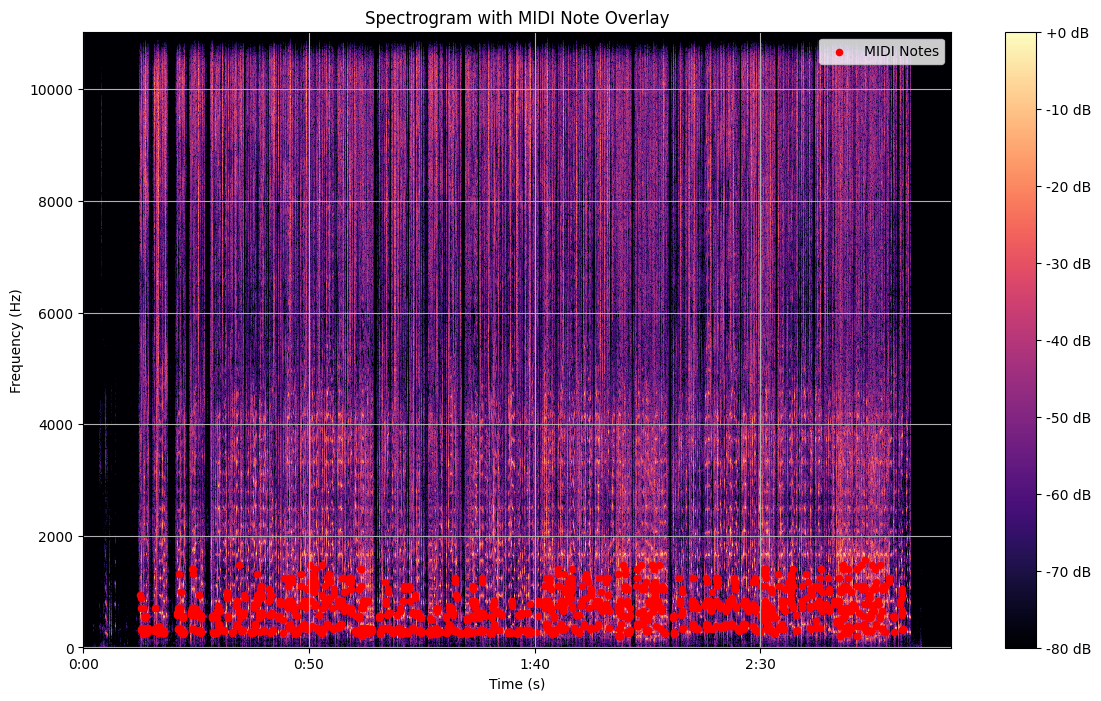

In [64]:
import librosa
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt

# Load audio and drum track for tempo extraction
song_path = "../samples/lastfm_samples/segmented/1390dfac67ae1ae28dcfcabb0021be8e/vocals.wav"
y, sr = librosa.load(song_path)
drum_path = "../samples/lastfm_samples/segmented/1390dfac67ae1ae28dcfcabb0021be8e/drums.wav"
y2, sr2 = librosa.load(drum_path)

# Step 1: RMS calculation and amplitude thresholding
frame_length = 2048
hop_length = 512
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
rms_threshold = np.mean(rms) + 0.5 * np.std(rms)
strong_segments = rms > rms_threshold

# Apply amplitude mask to isolate strong segments
y_filtered = np.copy(y)
for i, keep in enumerate(strong_segments):
    if not keep:
        start = i * hop_length
        end = min(start + frame_length, len(y))
        y_filtered[start:end] = 0

# Step 2: Extract tempo from the drum track
tempo = librosa.beat.tempo(y=y2, sr=sr2)[0]

# Step 3: Pitch detection with librosa.piptrack
def detect_pitch(y_segment, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y_segment, sr=sr, fmin=75, fmax=1600)
    max_indexes = np.argmax(magnitudes, axis=0)
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

pitches = detect_pitch(y_filtered, sr)
time_intervals = np.arange(len(pitches)) * (hop_length / sr)

# Step 4: Convert detected pitches to MIDI notes with durations
midi_notes = []
current_note = None
current_start_time = None

for time, pitch in zip(time_intervals, pitches):
    if pitch > 0:  # Active note
        midi_note = int(librosa.hz_to_midi(pitch))
        if current_note is None:  # New note start
            current_note = midi_note
            current_start_time = time
        elif midi_note != current_note:  # Change in pitch
            duration = time - current_start_time
            midi_notes.append((current_start_time, current_note, duration))
            current_note = midi_note
            current_start_time = time
    elif current_note is not None:  # End note on silence
        duration = time - current_start_time
        midi_notes.append((current_start_time, current_note, duration))
        current_note = None
        current_start_time = None

# Finalize the last active note if still present
if current_note is not None:
    duration = time_intervals[-1] - current_start_time
    midi_notes.append((current_start_time, current_note, duration))

# Step 5: Create MIDI file using extracted note timings and durations
midi_file = MIDIFile(1)
track = 0
midi_file.addTrackName(track, 0, "Matched Vocal MIDI")
midi_file.addTempo(track, 0, tempo)

# Add MIDI notes to the file
for start_time, midi_note, duration in midi_notes:
    midi_file.addNote(track, 0, midi_note, start_time, duration, 100)

# Save MIDI file
with open("matched_vocal_midi_output.mid", "wb") as output_file:
    midi_file.writeFile(output_file)
print("MIDI file created: matched_vocal_midi_output.mid")

# Visualization
# Step 6: Plot spectrogram with MIDI note overlay
plt.figure(figsize=(14, 8))

# Spectrogram
S = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with MIDI Note Overlay')

# Overlay MIDI notes on spectrogram
times, notes, durations = zip(*midi_notes)
midi_times = [start for start in times]
midi_pitches = [librosa.midi_to_hz(note) for note in notes]
plt.scatter(midi_times, midi_pitches, color='red', marker='o', s=20, label='MIDI Notes')

# Formatting and labels
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.show()


MIDI file created: melodia_extracted_midi_output.mid


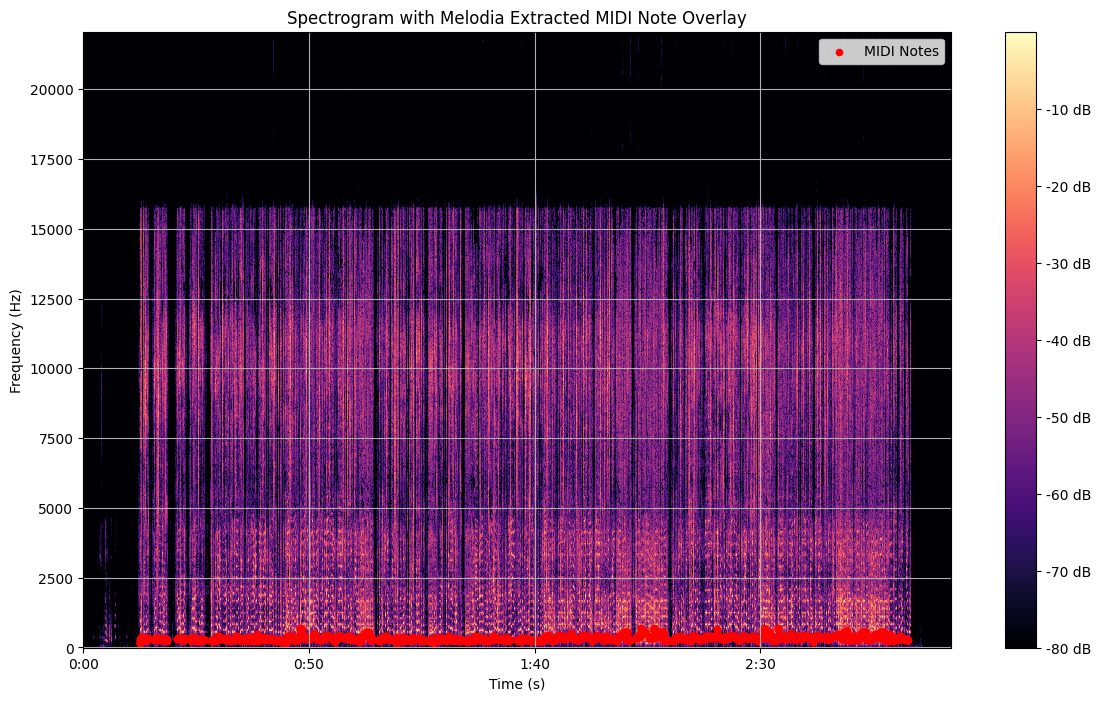

In [4]:
import vamp
import librosa
import essentia.standard as es
import matplotlib.pyplot as plt
import numpy as np
from midiutil import MIDIFile

# Load the audio file using Essentia
song_path = "../samples/lastfm_samples/segmented/1390dfac67ae1ae28dcfcabb0021be8e/vocals.wav"
loader = es.MonoLoader(filename=song_path, sampleRate=44100)
audio = loader()

# Step 1: Use Melodia to extract melody
sr = 44100
data = vamp.collect(audio, sr, "mtg-melodia:melodia")
hop, melody = data['vector']

# Convert hop to a float in seconds
hop = hop.to_float()  # This converts it to a standard float value in seconds
first_timestamp = 8 * hop  # Initial timestamp for the first pitch
timestamps = first_timestamp + np.arange(len(melody)) * hop

# Filter out unvoiced sections by setting negative values to None
melody_pos = melody.copy()
melody_pos[melody <= 0] = None

# Step 2: Convert frequencies to MIDI notes with durations
midi_notes = []
current_note = None
current_start_time = None

for time, pitch in zip(timestamps, melody):
    if pitch > 0:  # Only include voiced segments
        midi_note = int(librosa.hz_to_midi(pitch))
        if current_note is None:
            current_note = midi_note
            current_start_time = time
        elif midi_note != current_note:  # Note changed
            duration = time - current_start_time
            midi_notes.append((current_start_time, current_note, duration))
            current_note = midi_note
            current_start_time = time
    elif current_note is not None:  # End note on silence
        duration = time - current_start_time
        midi_notes.append((current_start_time, current_note, duration))
        current_note = None
        current_start_time = None

# Finalize last note if it is still active
if current_note is not None:
    duration = timestamps[-1] - current_start_time
    midi_notes.append((current_start_time, current_note, duration))

# Step 3: Create MIDI file with extracted notes and durations
midi_file = MIDIFile(1)
track = 0
midi_file.addTrackName(track, 0, "Melodia Extracted MIDI")
tempo = 120  # Set tempo (or detect if desired)
midi_file.addTempo(track, 0, tempo)

# Add notes to MIDI file
for start_time, midi_note, duration in midi_notes:
    midi_file.addNote(track, 0, midi_note, start_time, duration, 100)

# Save the MIDI file
with open("melodia_extracted_midi_output.mid", "wb") as output_file:
    midi_file.writeFile(output_file)

print("MIDI file created: melodia_extracted_midi_output.mid")

# Step 4: Visualization - Plot spectrogram and overlay extracted melody
plt.figure(figsize=(14, 8))

# Plot spectrogram
S = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=int(sr * hop))), ref=np.max)
librosa.display.specshow(S, sr=sr, hop_length=int(sr * hop), x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Melodia Extracted MIDI Note Overlay')

# Overlay MIDI notes on spectrogram
times, notes, durations = zip(*midi_notes)
midi_times = [start for start in times]
midi_pitches = [librosa.midi_to_hz(note) for note in notes]
plt.scatter(midi_times, midi_pitches, color='red', marker='o', s=20, label='MIDI Notes')

# Formatting and labels
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.show()


In [3]:
import os
import vamp

# Ensure the plugin path is set correctly
os.environ['VAMP_PATH'] = '/usr/local/lib/vamp'

# Test to see if the plugin loads
print(vamp.list_plugins())  # Look for "mtg-melodia:melodia"

['mtg-melodia:melodia', 'mtg-melodia:melodiaviz']
